In [1]:
import scipy
import scipy.io
import scipy.integrate
import scipy.signal
from scipy.signal import argrelextrema
import numpy as np
from numpy import linalg
from pydmd import DMD
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
import math

In [2]:
#mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A0PIVairfoil.mat')
#mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A2PIVu.mat')
#mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A5PIVboth.mat')
mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A10PIVairfoilall.mat')
data = list(mat.items())

u = data[8]
u_mean = data[9]
x = data[10]
y = data[11]
ts = data[3][1][0][0] # time step between snapshots

In [3]:
samples = len(u[1])             # number of snapshots in input data

h = len(u[1][1][1])             # height of matrix = y
l = len(u[1][1])                # length of matrix = x
h_trunc = 40                    # y truncation for input data
l_trunc = 140                   # x truncation for input data
n_modes = 10
t_trunc = samples                  # number of time snapshots for SVD
size = h_trunc*l_trunc
# t = np.linspace(0, t_trunc, ts) #time scale

print(samples)

6998


In [4]:
#print(x[1]) # [name "x"] __ [186 x coord arrays] __ [66 identical values]
xs = []
for i in range(0, l_trunc):
    xs.append(x[1][i][1])
print(len(xs))
ys = y[1][1][0:(h_trunc)]
print(len(ys))
print(len(xs)*len(ys))
xsgrid, ysgrid = np.meshgrid(xs, ys)

140
40
5600


(6998, 40, 140)


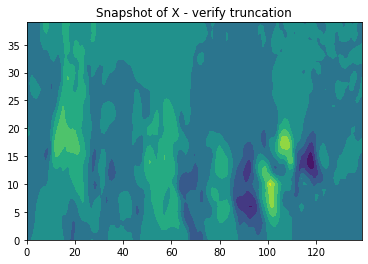

In [5]:
X = np.empty([samples,h_trunc,l_trunc])
print(np.shape(X))
for i in range(0,samples):
    X_man = np.rot90(u[1][i]-u_mean[1][0],3)
    X_man = np.delete(X_man, np.s_[h_trunc::], 0) # from top left, slice row 0:h. Parameter of 0 in np.delete defines rows
    X_man = np.delete(X_man, np.s_[0:l-l_trunc], 1) # from top left, slice column 0:l. Parameter of 1 in np.delete defines columns
    X[i] = np.fliplr(X_man)

fig, ax = plt.subplots()
cs = ax.contourf(X[samples-1])
ax.set_title('Snapshot of X - verify truncation')
plt.plot()
fig.canvas.draw()    

In [6]:
X = np.reshape(X, (samples,l_trunc*h_trunc))      # reshape X to contain all velocity points in second matrix dimension

X_trunc = np.transpose(np.delete(X, np.s_[t_trunc::], 0))   # truncate time resolution
print(np.shape(X_trunc))

(5600, 6998)


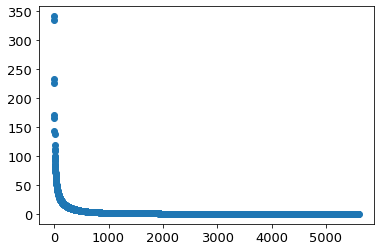

In [19]:
fig = plt.plot(scipy.linalg.svdvals(np.array([i.flatten() for i in X_trunc]).T), 'o')

In [7]:
dmd = DMD(svd_rank=n_modes, tlsq_rank=0, exact=True, opt=True) #svd_rank of 0 auto-selects truncation rank. In some cases, 
#singular values should be examined in order to select the proper truncation.
#DO NOT AUTO-SELECT WITH AOA = 10
dmd.fit(X_trunc)
# u = lamda w

D:\Anaconda3\lib\site-packages\pydmd\dmdbase.py:348: UserWarning: Input data matrix X has condition number 1.8615507898786028e+18. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn(


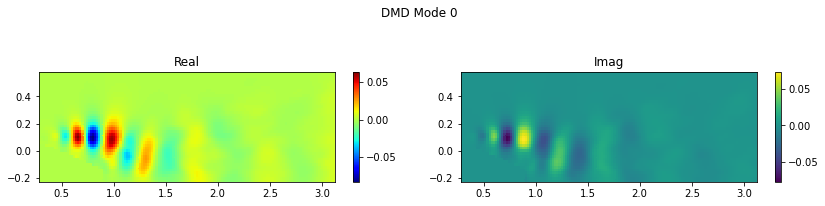

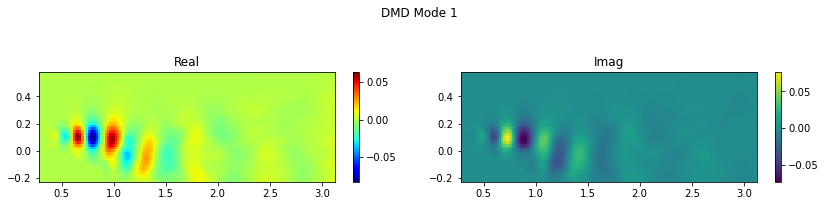

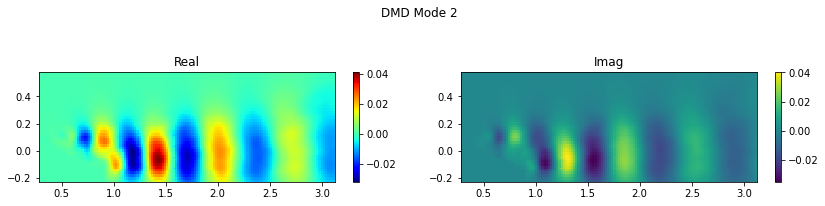

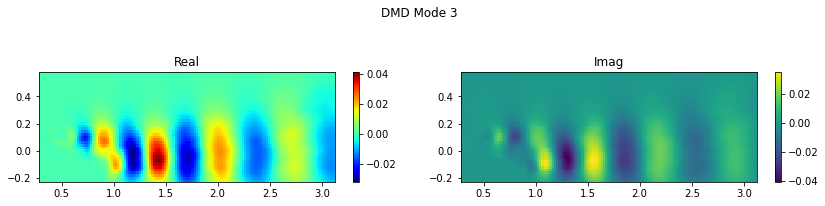

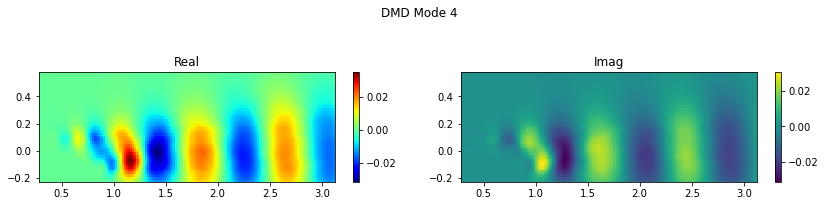

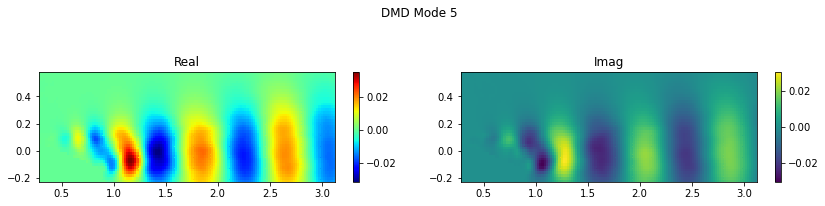

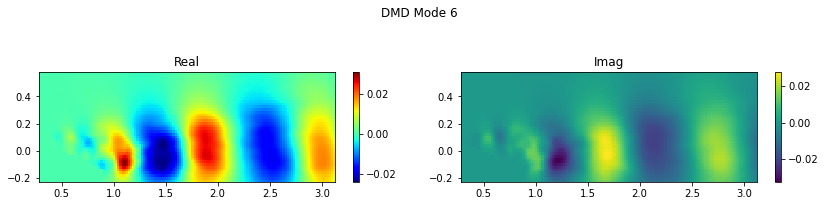

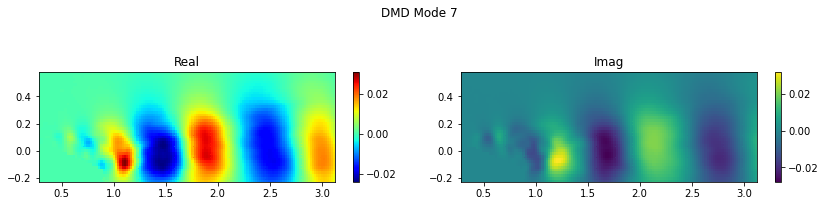

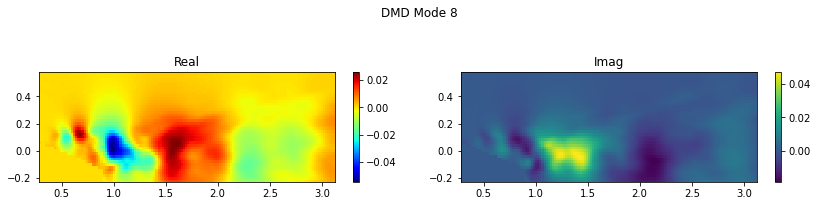

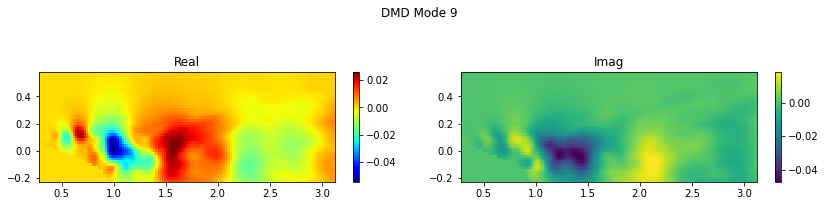

In [8]:
dmd.plot_modes_2D(x=xs, y=ys, figsize=(12,3))

In [9]:
import csv
filename = "dmd_10.csv"
with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(np.rot90(dmd.modes.real))
    #csvwriter.writerows(np.rot90(dmd.modes.imag))

Eigenvalue (0.9945261187606524+0.07622514153414525j): distance from unit circle 0.005107526900972159
Eigenvalue (0.9945261187606524-0.07622514153414525j): distance from unit circle 0.005107526900972159
Eigenvalue (0.9971694744766695+0.06351774728261671j): distance from unit circle 0.001618534952064432
Eigenvalue (0.9971694744766695-0.06351774728261671j): distance from unit circle 0.001618534952064432
Eigenvalue (0.9979349537439088+0.05218525043843491j): distance from unit circle 0.0014025277328203467
Eigenvalue (0.9979349537439088-0.05218525043843491j): distance from unit circle 0.0014025277328203467
Eigenvalue (0.9979214197721671+0.04077285698946912j): distance from unit circle 0.0024904140928186935
Eigenvalue (0.9979214197721671-0.04077285698946912j): distance from unit circle 0.0024904140928186935
Eigenvalue (0.9964845361942536+0.024001107330166433j): distance from unit circle 0.00644251597264911
Eigenvalue (0.9964845361942536-0.024001107330166433j): distance from unit circle 0.0064

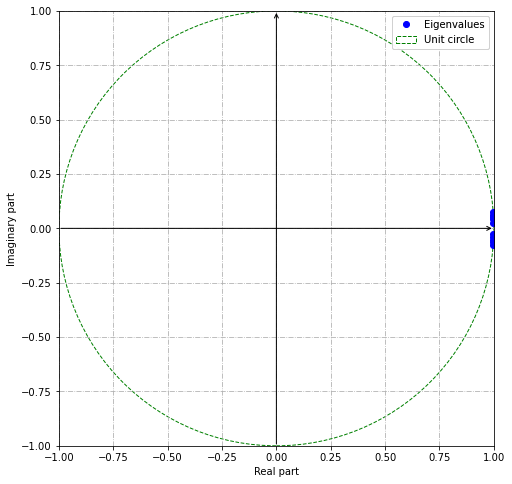

In [10]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

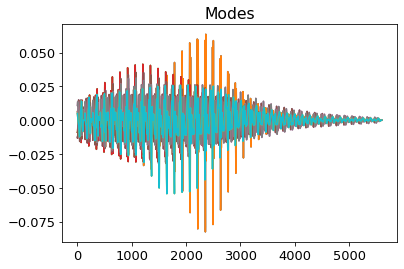

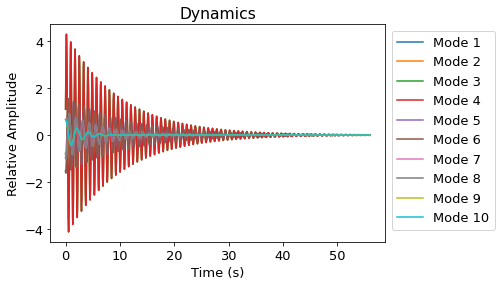

In [33]:
for mode in dmd.modes.T:
    plt.plot(mode.real)
    plt.title('Modes')
plt.show()


t = np.linspace(0, samples*ts, samples)
i=0
for dynamic in dmd.dynamics:
    #plt.ylim(-4.5, 4.5)
    #plt.xlim(0, 5)
    plt.plot(t, dynamic.real, label='Mode '+str(i+1))
    plt.title('Dynamics')
    i = i+1
plt.xlabel('Time (s)')
plt.ylabel('Relative Amplitude')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

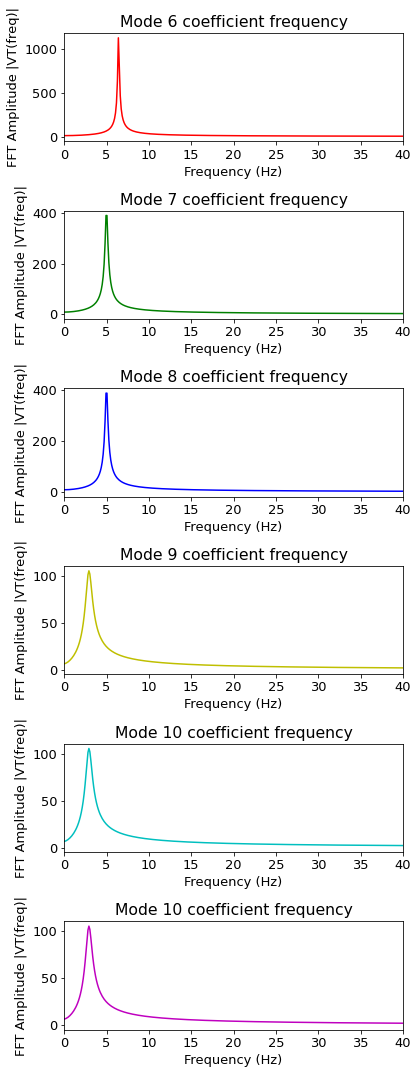

In [25]:
# Source: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html
from numpy.fft import fft, ifft # using fast fourier transform to find the discrete frequencies of the signal

mode_no = [0,1,2,3,4,5]
mode_no = [5,6,7,8,9,9]

Freq0 = np.flip(fft(dmd.dynamics.real[mode_no[0]]))
Freq1 = np.flip(fft(dmd.dynamics.real[mode_no[1]]))
Freq2 = np.flip(fft(dmd.dynamics.real[mode_no[2]]))
Freq3 = np.flip(fft(dmd.dynamics.real[mode_no[3]]))
Freq4 = np.flip(fft(dmd.dynamics.real[mode_no[4]]))
Freq5 = np.flip(fft(dmd.dynamics.real[mode_no[5]]))

N = len(Freq0)
n = np.arange(N/2)
sr = 1/ts # sampling rate, Hz
t = np.arange(0,N/sr,ts)
# Get the one-sided specturm
n_oneside = int(N/2)
# get the one side frequency
f_oneside = n*2*np.pi*sr/(2*n_oneside)
xmax = 40 #sr

fig, (plt0,plt1,plt2,plt3,plt4,plt5) = plt.subplots(6, figsize = (6,15))
plt.rc('font', size=13) #controls default text size

plt0.plot(f_oneside, np.abs(Freq0[:n_oneside]), 'r')
plt1.plot(f_oneside, np.abs(Freq1[:n_oneside]), 'g')
plt2.plot(f_oneside, np.abs(Freq2[:n_oneside]), 'b')
plt3.plot(f_oneside, np.abs(Freq3[:n_oneside]), 'y')
plt4.plot(f_oneside, np.abs(Freq4[:n_oneside]), 'c')
plt5.plot(f_oneside, np.abs(Freq5[:n_oneside]), 'm')
#plt0.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt1.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt2.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt3.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt4.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt5.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
plt0.set_xlim(0, xmax)
plt1.set_xlim(0, xmax)
plt2.set_xlim(0, xmax)
plt3.set_xlim(0, xmax)
plt4.set_xlim(0, xmax)
plt5.set_xlim(0, xmax)

plt0.set_xlabel('Frequency (Hz)')
plt0.set_ylabel('FFT Amplitude |VT(freq)|')
plt1.set_xlabel('Frequency (Hz)')
plt1.set_ylabel('FFT Amplitude |VT(freq)|')
plt2.set_xlabel('Frequency (Hz)')
plt2.set_ylabel('FFT Amplitude |VT(freq)|')
plt3.set_xlabel('Frequency (Hz)')
plt3.set_ylabel('FFT Amplitude |VT(freq)|')
plt4.set_xlabel('Frequency (Hz)')
plt4.set_ylabel('FFT Amplitude |VT(freq)|')
plt5.set_xlabel('Frequency (Hz)')
plt5.set_ylabel('FFT Amplitude |VT(freq)|')

plt0.set_title('Mode ' + str(mode_no[0]+1) + ' coefficient frequency')
plt1.set_title('Mode ' + str(mode_no[1]+1) + ' coefficient frequency')
plt2.set_title('Mode ' + str(mode_no[2]+1) + ' coefficient frequency')
plt3.set_title('Mode ' + str(mode_no[3]+1) + ' coefficient frequency')
plt4.set_title('Mode ' + str(mode_no[4]+1) + ' coefficient frequency')
plt5.set_title('Mode ' + str(mode_no[5]+1) + ' coefficient frequency')

plt.tight_layout()
plt.show()

In [24]:
peaks = np.zeros(n_modes)
for i in range(0,n_modes):
    Freq = np.flip(fft(dmd.dynamics.real[i]))
    #peaks.append(scipy.signal.find_peaks(vars()['Freq' + str(i)])[0][0])
    try:
        f = (argrelextrema(Freq, np.greater)[0][0]+argrelextrema(Freq, np.less)[0][0])/2*2*np.pi*sr/(2*n_oneside)
        print(f)
        if f < 100:
            peaks[i] = (f)
        else:
            peaks[i] = argrelextrema(Freq, np.greater)[0][0]*2*np.pi*sr/(2*n_oneside)
            #modes 9/10 bugged at np.lesser. This value is accurate from FFT
    except:
        peaks[i] = 0
#peaks = peaks.reshape(n,1)
print(peaks, type(peaks))

#peaks.tofile('dmd_freqs.csv', sep = ',')
np.savetxt('dmd_freqs.csv', peaks, delimiter = ',')

9.82028283756455
9.82028283756455
7.85622627005164
7.85622627005164
6.677792329543894
6.677792329543894
5.499358389036148
5.499358389036148
197.75243839758556
197.75243839758556
[9.82028284 9.82028284 7.85622627 7.85622627 6.67779233 6.67779233
 5.49935839 5.49935839 2.9180269  2.9180269 ] <class 'numpy.ndarray'>
